In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hydra import compose, initialize
import numpy as np
import os
import dotenv
import pickle
import pathlib
import textwrap
from sklearn.metrics import classification_report
import wandb
from procan_connectome.data_processing.pipeline import get_pipeline
from procan_connectome.data_ingestion.ingest_data import get_dataset
from procan_connectome.utils.result_plots import _generate_confusion_matrix, plot_feature_importance


In [ ]:
# change id
_SWEEP_ID="4tleci5g"

feature_map_df = pd.read_csv("../data/AAL_description.csv")

results = pd.read_csv(f"../processed_results_{_SWEEP_ID}.csv", index_col="id")
results = results.loc[(results["state"].isin(["finished"])) & (results["sweep_id"]==_SWEEP_ID)]
results.shape

(80, 72)

In [3]:
independent_cols = ["model", "dataset", "pipeline.rfecv", "loocv.balance_classes", "pipeline.power_transform", "pipeline.standard_scale"]

In [4]:
results.groupby(independent_cols).agg(["mean", "std", "min", "max", "count"])[["Accuracy", "F1-Score (macro)"]].sort_values(by=("F1-Score (macro)", "mean"), ascending=False).dropna()

C:\Users\zeyad\AppData\Local\Temp\ipykernel_39404\1002671365.py:1: FutureWarning: ['Confusion Matrix._type', 'Confusion Matrix.caption', 'Confusion Matrix.format', 'Confusion Matrix.path', 'Confusion Matrix.sha256', 'Top 10 Feature Importances._type', 'Top 10 Feature Importances.caption', 'Top 10 Feature Importances.format', 'Top 10 Feature Importances.path', 'Top 10 Feature Importances.sha256', 'Top 50 Feature Importances._type', 'Top 50 Feature Importances.caption', 'Top 50 Feature Importances.format', 'Top 50 Feature Importances.path', 'Top 50 Feature Importances.sha256', 'config', 'labels_dict.0', 'labels_dict.1', 'labels_dict.2', 'labels_dict.3', 'labels_dict.4', 'loocv.scoring', 'name', 'paths.data', 'paths.logs', 'paths.plot', 'paths.root', 'paths.t12_data', 'pipeline.ignore_features', 'state', 'summary', 'sweep_id', 'tags', 'wandb.dir', 'wandb.entity', 'wandb.name', 'wandb.project', 'wandb.start_method'] did not aggregate successfully. If any error is raised this will raise in 

Accuracy  \
                                                                                                                 mean   
model dataset         pipeline.rfecv loocv.balance_classes pipeline.power_transform pipeline.standard_scale             
rf    cross_sectional True           True                  True                     False                    0.559494   
                                     False                 False                    True                     0.563924   
                                     True                  False                    True                     0.559494   
                                     False                 False                    False                    0.565190   
                                                           True                     True                     0.564557   
                                     True                  False                    False                    0.555063   
                                     False                 True                     False                    0.558228   
                                     True                  True                     True                     0.548101   

                                                                                                                       \
                                                                                                                  std   
model dataset         pipeline.rfecv loocv.balance_classes pipeline.power_transform pipeline.standard_scale             
rf    cross_sectional True           True                  True                     False                    0.019610   
                                     False                 False                    True                     0.025220   
                                     True                  False                    True                     0.030747   
                                     False                 False                    False                    0.023120   
                                                           True                     True                     0.017087   
                                     True                  False                    False                    0.020026   
                                     False                 True                     False                    0.019058   
                                     True                  True                     True                     0.019151   

                                                                                                                       \
                                                                                                                  min   
model dataset         pipeline.rfecv loocv.balance_classes pipeline.power_transform pipeline.standard_scale             
rf    cross_sectional True           True                  True                     False                    0.531646   
                                     False                 False                    True                     0.531646   
                                     True                  False                    True                     0.525316   
                                     False                 False                    False                    0.512658   
                                                           True                     True                     0.537975   
                                     True                  False                    False                    0.525316   
                                     False                 True                     False                    0.518987   
                                     True                  True                     True                     0.512658   

                                                                                                                 

In [5]:
best_config = results.groupby(independent_cols).agg(["mean", "std", "min", "max", "count"])[["Accuracy", "F1-Score (macro)"]].sort_values(by=("F1-Score (macro)", "mean"), ascending=False).dropna().iloc[3]
best_runs_ids = results.loc[
            (results["model"]==best_config.name[0]) &
            (results["dataset"]==best_config.name[1]) & 
            (results["pipeline.rfecv"]==best_config.name[2]) & 
            (results["loocv.balance_classes"]==best_config.name[3]) & 
            (results["pipeline.power_transform"]==best_config.name[4]) & 
            (results["pipeline.standard_scale"]==best_config.name[5])
        ].index
best_runs = results.loc[best_runs_ids].sort_values(by=["F1-Score (macro)"],ascending=False)
best_runs

C:\Users\zeyad\AppData\Local\Temp\ipykernel_39404\3153374933.py:1: FutureWarning: ['Confusion Matrix._type', 'Confusion Matrix.caption', 'Confusion Matrix.format', 'Confusion Matrix.path', 'Confusion Matrix.sha256', 'Top 10 Feature Importances._type', 'Top 10 Feature Importances.caption', 'Top 10 Feature Importances.format', 'Top 10 Feature Importances.path', 'Top 10 Feature Importances.sha256', 'Top 50 Feature Importances._type', 'Top 50 Feature Importances.caption', 'Top 50 Feature Importances.format', 'Top 50 Feature Importances.path', 'Top 50 Feature Importances.sha256', 'config', 'labels_dict.0', 'labels_dict.1', 'labels_dict.2', 'labels_dict.3', 'labels_dict.4', 'loocv.scoring', 'name', 'paths.data', 'paths.logs', 'paths.plot', 'paths.root', 'paths.t12_data', 'pipeline.ignore_features', 'state', 'summary', 'sweep_id', 'tags', 'wandb.dir', 'wandb.entity', 'wandb.name', 'wandb.project', 'wandb.start_method'] did not aggregate successfully. If any error is raised this will raise in 

,Accuracy,Confusion Matrix._type,Confusion Matrix.caption,Confusion Matrix.format,Confusion Matrix.height,Confusion Matrix.path,Confusion Matrix.sha256,Confusion Matrix.size,Confusion Matrix.width,F1-Score (macro),...,random_seed,state,summary,sweep_id,tags,wandb.dir,wandb.entity,wandb.name,wandb.project,wandb.start_method
id,,,,,,,,,,,,,,,,,,,,,
mucuv189,0.594937,image-file,Confusion Matrix,png,1009,media/images/Confusion Matrix_160_5c8b8a8cdfa1...,5c8b8a8cdfa1c89dc3f47a09995b2bbd277ebc0c2bf86e...,74397,1258,0.571560,...,98,finished,"{'Accuracy': 0.5949367088607594, 'Confusion Ma...",4tleci5g,[],/home/zeyad.abouyoussef/procan_connectome/data...,zeyadk-university-of-calgary-in-alberta,rf_cross_sectional_gsTrue_ssFalse_ptFalse_rfec...,procan,thread
k6f13nzk,0.588608,image-file,Confusion Matrix,png,1009,media/images/Confusion Matrix_160_9131b0037dfa...,9131b0037dfa39f1dffef1dd9469da26c984c7a6d22cd8...,75519,1258,0.551225,...,32,finished,"{'Accuracy': 0.5886075949367089, 'Confusion Ma...",4tleci5g,[],/home/zeyad.abouyoussef/procan_connectome/data...,zeyadk-university-of-calgary-in-alberta,rf_cross_sectional_gsTrue_ssFalse_ptFalse_rfec...,procan,thread
2fv9yn8l,0.582278,image-file,Confusion Matrix,png,1009,media/images/Confusion Matrix_160_fe9fd2632ba8...,fe9fd2632ba8f0c332971ede7762961fc3b05d2ddd26b1...,73883,1258,0.551193,...,23,finished,"{'Accuracy': 0.5822784810126582, 'Confusion Ma...",4tleci5g,[],/home/zeyad.abouyoussef/procan_connectome/data...,zeyadk-university-of-calgary-in-alberta,rf_cross_sectional_gsTrue_ssFalse_ptFalse_rfec...,procan,thread
hm44h8x6,0.563291,image-file,Confusion Matrix,png,1009,media/images/Confusion Matrix_160_cf982b4b709c...,cf982b4b709cedad79c9288ec7fe7b9cd35a8b192135b5...,77907,1258,0.539258,...,4,finished,"{'Accuracy': 0.5632911392405063, 'Confusion Ma...",4tleci5g,[],/home/zeyad.abouyoussef/procan_connectome/data...,zeyadk-university-of-calgary-in-alberta,rf_cross_sectional_gsTrue_ssFalse_ptFalse_rfec...,procan,thread
a1u8k31s,0.569620,image-file,Confusion Matrix,png,1009,media/images/Confusion Matrix_160_17a670c2c1f2...,17a670c2c1f288c1c227ddaf6529cbebc2e8ec6c285233...,74063,1258,0.537472,...,2078,finished,"{'Accuracy': 0.569620253164557, 'Confusion Mat...",4tleci5g,[],/home/zeyad.abouyoussef/procan_connectome/data...,zeyadk-university-of-calgary-in-alberta,rf_cross_sectional_gsTrue_ssFalse_ptFalse_rfec...,procan,thread
fpo8fu3y,0.569620,image-file,Confusion Matrix,png,1009,media/images/Confusion Matrix_160_713c30b0e3a7...,713c30b0e3a75aa611da45cc73d27fa9971955b516db68...,75907,1258,0.535319,...,8746,finished,"{'Accuracy': 0.569620253164557, 'Confusion Mat...",4tleci5g,[],/home/zeyad.abouyoussef/procan_connectome/data...,zeyadk-university-of-calgary-in-alberta,rf_cross_sectional_gsTrue_ssFalse_ptFalse_rfec...,procan,thread
qivxgh08,0.550633,image-file,Confusion Matrix,png,1009,media/images/Confusion Matrix_160_84d59a85bbe2...,84d59a85bbe2e8c12a1662795bfed5e1de544de6baa165...,73567,1258,0.534508,...,8,finished,"{'Accuracy': 0.5506329113924051, 'Confusion Ma...",4tleci5g,[],/home/zeyad.abouyoussef/procan_connectome/data...,zeyadk-university-of-calgary-in-alberta,rf_cross_sectional_gsTrue_ssFalse_ptFalse_rfec...,procan,thread
m6ka4j4p,0.563291,image-file,Confusion Matrix,png,1009,media/images/Confusion Matrix_160_ae8bd6df7b28...,ae8bd6df7b2815d5c4995fbc472ff0ae03ef4f06447167...,76351,1258,0.533885,...,12,finished,"{'Accuracy': 0.5632911392405063, 'Confusion Ma...",4tleci5g,[],/home/zeyad.abouyoussef/procan_connectome/data...,zeyadk-university-of-calgary-in-alberta,rf_cross_sectional_gsTrue_ssFalse_ptFalse_rfec...,procan,thread
6w1eq4wa,0.556962,image-file,Confusion Matrix,png,1009,media/images/Confusion Matrix_160_7c68b6d95d0e...,7c68b6d95d0ee827a2fae9cee1bb240985e7388cb9fa72...,73321,1258,0.530833,...,42,finished,"{'Accuracy': 0.5569620253164557, 'Confusion Ma...",4tleci5g,[],/home/zeyad.abouyoussef/procan_connectome/data...,zeyadk-university-of-calgary-in-alberta,rf_cross_sectional_gsTrue_ssFals

In [6]:
best_config

Accuracy          mean      0.565190
                  std       0.023120
                  min       0.512658
                  max       0.594937
                  count    10.000000
F1-Score (macro)  mean      0.536163
                  std       0.024333
                  min       0.476373
                  max       0.571560
                  count    10.000000
Name: (rf, cross_sectional, True, False, False, False), dtype: float64

In [ ]:
models_save_dir = f"{_SWEEP_ID}/best_runs_pkls/"
os.makedirs(models_save_dir,exist_ok=True)

api = wandb.Api()
for run_id, cols in best_runs.iterrows():
    api.run(f"zeyadk-university-of-calgary-in-alberta/procan/{run_id}").logged_artifacts()[0].download(root=models_save_dir)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [ ]:
models = []
for _, cols in best_runs.iterrows():
    # A hack for loading a linux pickled file on windows 
    posix_backup = pathlib.PosixPath
    try:
        pathlib.PosixPath = pathlib.WindowsPath
        with open(os.path.join(models_save_dir, cols["wandb.name"] + ".pkl"), "rb") as handle:
            models.append(pickle.load(handle))
    finally:
        pathlib.PosixPath = posix_backup


models[0]

LOOCV_Wrapper(X=              fun_Density  fun_Intensity    fun_HM  fun_Assortativity  \
Subject Site                                                            
1       2        0.307971       0.426187  0.037389           7.278813   
2       2        0.279863       0.444237  0.072894          18.750108   
3       2        0.307977       0.447196  0.054797          15.904290   
4       1        0.360845       0.480402  0.045966          16.817162   
        2        0.287866       0.442422  0.050767           6.237570   
...                   ...            ...       ...                ...   
197     1        0.392498       0.490387  0.034671          30.880972   
198     1        0.293189       0.427460  0.073524          20.452503   
199     1        0.307897       0....
        random_state=RandomState(MT19937) at 0x139A2117240, shuffle=True),
                                                                                      estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x139A2116F40),
                                                                                      min_features_to_select=10,
                                                                                      n_jobs=-1,
                                                                                      step=0.1,
                                                                                      verbose=10)))]),
              random_seed=98, save_feature_importance=True, scoring='f1_macro',
              y=Subject  Site
1        2       2.0
2        2       0.0
3        2       1.0
4        1       1.0
         2       1.0
                ... 
197      1       1.0
198      1       1.0
199      1       1.0
200      1       3.0
201      1       1.0
Name: Group, Length: 158, dtype: float64)

In [10]:
with initialize("../configs", version_base="1.2.0"):
    cfg = compose(
        "config.yaml"
    )
dotenv.load_dotenv("../.env", override=True)

_PLOT_PATH = pathlib.Path(f"{_SWEEP_ID}") / "plots"
os.makedirs(_PLOT_PATH,exist_ok=True)

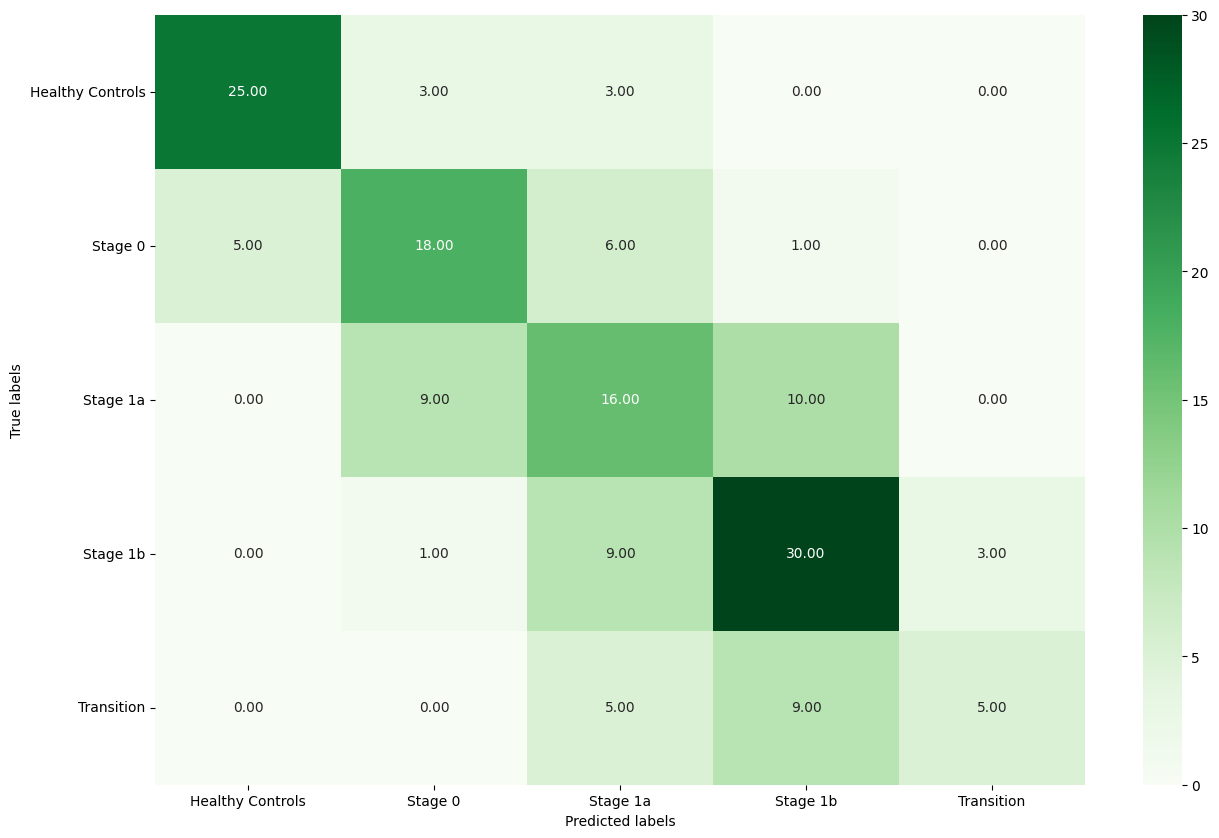

In [13]:
# plot confusion matrix of best result
best_model = models[0]
cm_fig = _generate_confusion_matrix(cfg, best_model.results_df_, plot_path=None)
ax = cm_fig.axes
ax[0].set_title(None)
cm_fig.savefig(_PLOT_PATH / "cm.pdf", bbox_inches="tight")
cm_fig.savefig(_PLOT_PATH / "cm.svg", bbox_inches="tight")

In [ ]:
print(classification_report(best_model.results_df_.y_true,best_model.results_df_.y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82        31
         1.0       0.58      0.60      0.59        30
         2.0       0.41      0.46      0.43        35
         3.0       0.60      0.70      0.65        43
         4.0       0.62      0.26      0.37        19

    accuracy                           0.59       158
   macro avg       0.61      0.56      0.57       158
weighted avg       0.60      0.59      0.59       158



In [17]:
feature_map_df

,Index,Regions,Abbreviation
0,"(1,2)",Precental gyrus,PreCG
1,"(3,4)","Superior frontal gyrus, dorsolateral",SFGdor
2,"(5,6)","Superior frontal gyrus, orbital part",ORBsup
3,"(7,8)",Middle frontal gyrus,MFG
4,"(9,10)","Middle frontal gyrus, orbital part",ORBmid
5,"(11,12)","Inferior frontal gyrus, opercular part",IFGoperc
6,"(13,14)","Inferior frontal gyrus, triangular part",IFGtriang
7,"(15,16)","Inferior frontal gyrus, orbital part",ORBinf
8,"(17,18)",Rolandic operculum,ROL
9,"(19,20)",Supplementary motor area,SMA


In [ ]:
def axis_title_wrapper(name, max_l=20):
    try:
        new_name = "\n".join(textwrap.wrap(name, width=max_l))
        return new_name
    except:
        return name
    

 
def feature_name_map(name, feature_map_df=feature_map_df, delim=" ", wrap_len=None):
    try:
        _type_map = {"str": "DTI", "fun": "fMRI"}
        _node_map = {
            "Bc": f"betweenness{delim}centrality",
            "Dc": f"degree{delim}centrality",
            "Nsp": f"nodal{delim}shortest{delim}path",
            "Ne": f"nodal{delim}efficiency",
            "Pc": f"participant{delim}coefficient",
            "Ncc": f"nodal{delim}clustering{delim}coefficient",
            "Nle": f"nodal{delim}local{delim}efficiency",
            }
        _modular_interactions_map = {
            '1': "visual",
            '2': "somatomotor",
            '3': "dorsal attention",
            '4': "ventral attention",
            '5': "limbic",
            '6': "fronto-parietal",
            '7': "default mode",
            '8': "deep grey matter"
        }

        # TODO need to add global metrics        
        
        _period_map = {'0': "baseline", '1': "follow-up"}
        name_comps = name.split("_")
        
        if name_comps[0] == "cog":
            if name[-2:] in ["_0", "_1"]:
                _, *feature, period = name_comps
                period = _period_map[period]
            else:
                _, *feature= name_comps
                period = ""
            return delim.join([*feature, period]).rstrip(" ")
        else:
            if name[-2:] in ["_0", "_1"]:
                scan_type, metric, region, period = name_comps
                period = _period_map[period]
            else:
                scan_type, metric, region = name_comps
                period = ""

            scan_type = _type_map[scan_type]
            node_metric = _node_map.get(metric)
            if node_metric:
                metric = node_metric
                if region[0]=="V":
                    region = region[1:]
                region = int(region)
                if region %2 == 0:
                    region_idx = region//2
                    region_hemispehre = "L"
                else:
                    region_idx = (region+1)//2
                    region_hemispehre="R"
                region = feature_map_df.iloc[region_idx]["Regions"]
                region = region.lower()
                region = region.split(" ")
                region = delim.join(region)
            elif metric == "SE":
                metric = f"sum{delim}edges"
                region = str(region)
                if len(region) == 1:
                    region = "within" + delim + _modular_interactions_map[region]
                else:
                    region = "between" + delim + _modular_interactions_map[region[0]] + delim + "and" + delim + _modular_interactions_map[region[1]]

                region_hemispehre = ""

            converted_name = delim.join(
                    filter(None, [scan_type, metric, region, region_hemispehre, period])
                )
            if wrap_len is not None:
                return axis_title_wrapper(converted_name, max_l=wrap_len)
            return converted_name.rstrip(" ")
    except:
        return name


name = "cog_SOPS_neg_0"
feature_name_map(name, feature_map_df, delim=" ", wrap_len=30)
name = "str_Bc_V63"
feature_name_map(name, feature_map_df, delim=" ", wrap_len=30)
# name = "fun_SE_47_0"
# feature_name_map(name, feature_map_df, delim=" ", wrap_len=30)
# name = "fun_SE_7_0"
# feature_name_map(name, feature_map_df, delim=" ", wrap_len=30)

'DTI betweenness centrality\nangular gyrus R'

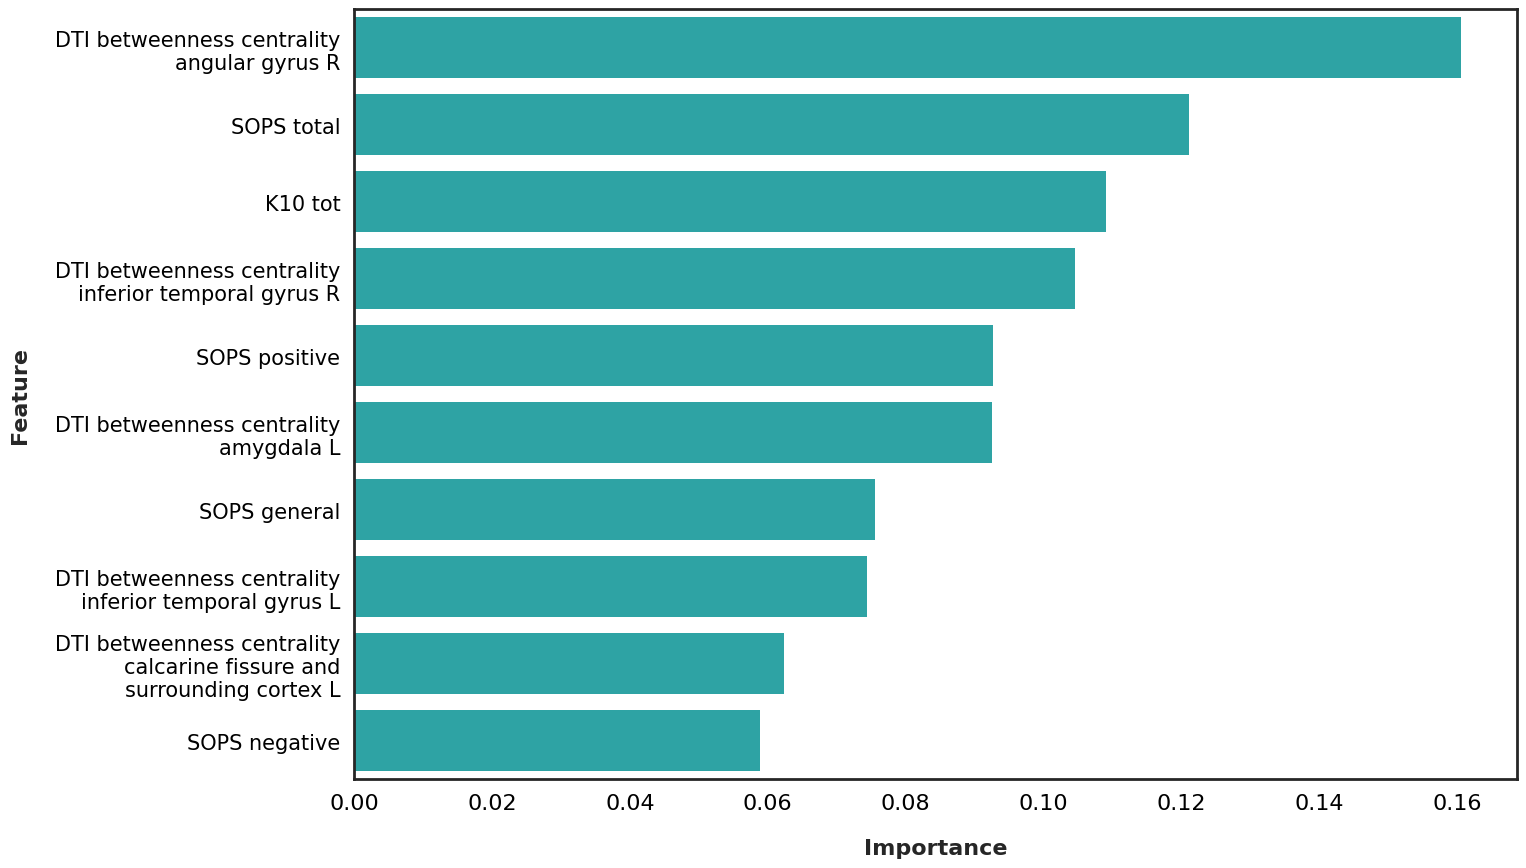

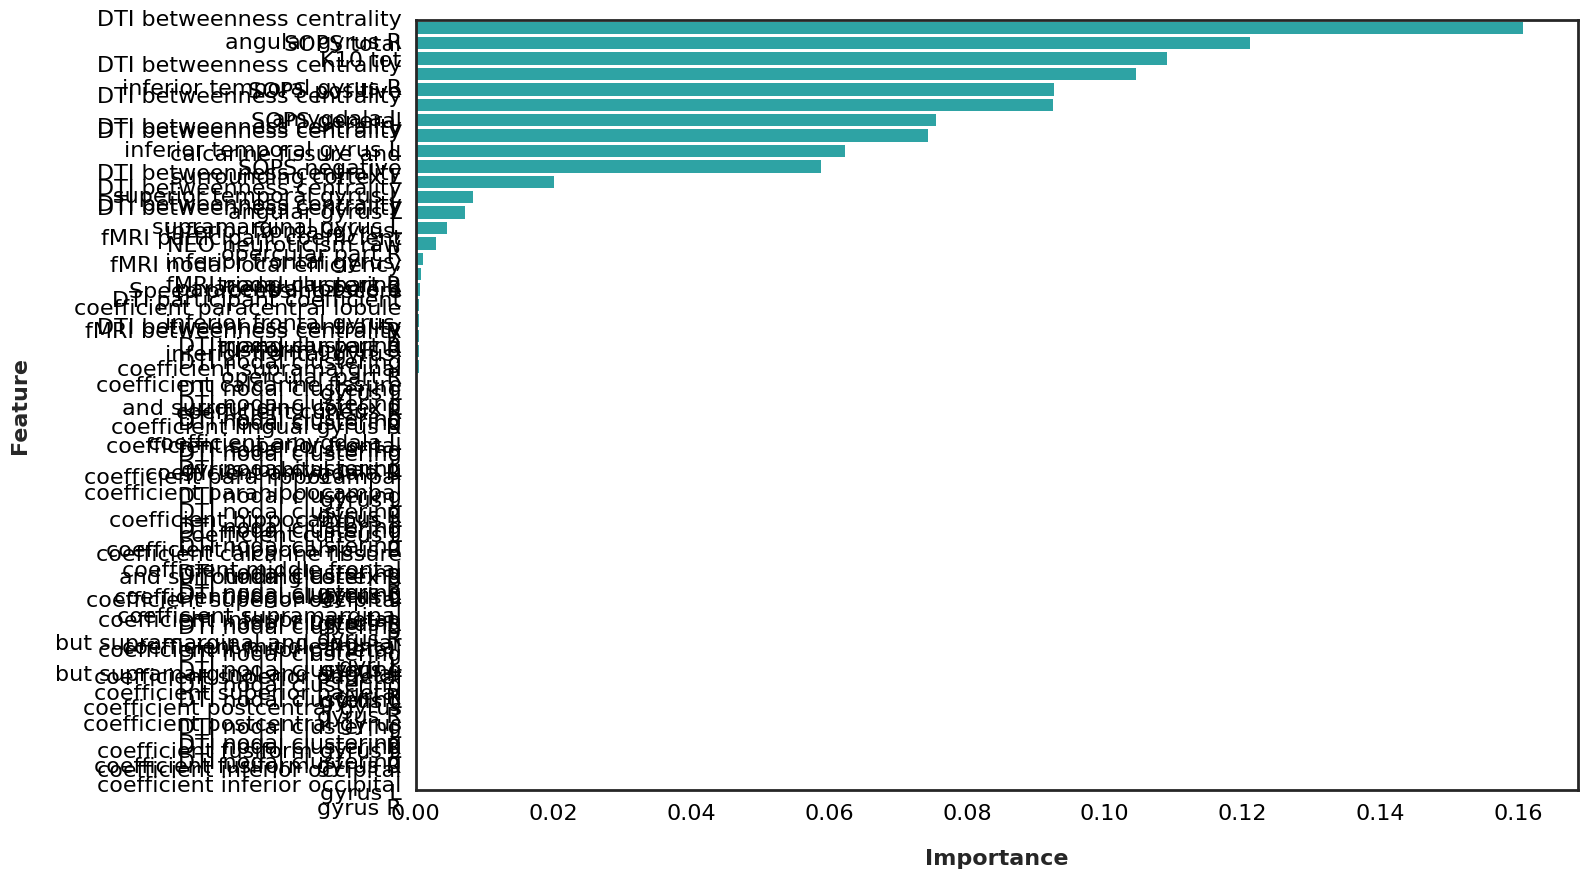

In [ ]:
plt.style.use("../plots/plt_plot_style.mplstyle")

feature_importances_df = (
                best_model.importances_.fillna(0).mean(axis=1).rename("Importance")
            )

feature_importances_df = feature_importances_df.rename(lambda name: feature_name_map(name, wrap_len=30))

fi_fig = plot_feature_importance(
    feature_importances_df,
    "Top 10 Features",
    feature_col="Feature",
    importance_col="Importance",
    n_features=10,
    plot_path=None,
)
ax = fi_fig.axes
ax[0].tick_params(axis="y", labelsize=15)

ax[0].set_title(None)
fi_fig.savefig(_PLOT_PATH / "apa-top-10-features.pdf", bbox_inches="tight")
fi_fig.savefig(_PLOT_PATH / "apa-top-10-features.svg", bbox_inches="tight")

# fi_fig = plot_feature_importance(
#     feature_importances_df,
#     "Top 50 Features",
#     feature_col="Feature",
#     importance_col="Importance",
#     n_features=50,
#     plot_path=None,
# )
# ax = fi_fig.axes
# ax[0].set_title(None)
# fi_fig.savefig(_PLOT_PATH / "apa-top-50-features.pdf", bbox_inches="tight")
# fi_fig.savefig(_PLOT_PATH / "apa-top-50-features.svg", bbox_inches="tight")

In [ ]:
model_importances = [model.importances_.fillna(0).mean(axis=1).rename(f"model_{i}_Importance").to_frame() for i,model in enumerate(models)]
global_importances = model_importances[0].join(model_importances[1:]).mean(axis=1).rename(f"Importance").to_frame()
global_importances.sort_values("Importance",ascending=False).iloc[:50]

,Importance
Feature,
str_Bc_V63,0.161555
cog_SOPS_total,0.125706
cog_K10_tot,0.104839
str_Bc_V87,0.099310
cog_SOPS_positive,0.095079
str_Bc_V40,0.091461
str_Bc_V88,0.073438
cog_SOPS_general,0.070327
str_Bc_V42,0.061957


In [22]:
common_top_10 = []

def get_top_x(series, x):
    return series.sort_values(ascending=False).iloc[:x].index

top_10  = get_top_x(feature_importances_df, 10)


for feature in top_10:
    common = True
    for model in models:
        if feature not in get_top_x(model.importances_.fillna(0).mean(axis=1).rename(f"Importance").rename(lambda name: feature_name_map(name, wrap_len=30)), 10):
            common = False
            break
    if common:
        common_top_10.append(feature)

common_top_10

['DTI betweenness centrality\nangular gyrus R',
 'SOPS total',
 'K10 tot',
 'DTI betweenness centrality\ninferior temporal gyrus R',
 'SOPS positive',
 'DTI betweenness centrality\namygdala L',
 'SOPS general',
 'DTI betweenness centrality\ninferior temporal gyrus L',
 'DTI betweenness centrality\ncalcarine fissure and\nsurrounding cortex L',
 'SOPS negative']

In [23]:
common_top_50 = []
top_50 = get_top_x(feature_importances_df, 50)
for feature in top_10:
    common = True
    for model in models:
        if feature not in get_top_x(model.importances_.fillna(0).mean(axis=1).rename(f"Importance").rename(lambda name: feature_name_map(name, wrap_len=30)), 50):
            common = False
            break
    if common:
        common_top_50.append(feature)
common_top_50

['DTI betweenness centrality\nangular gyrus R',
 'SOPS total',
 'K10 tot',
 'DTI betweenness centrality\ninferior temporal gyrus R',
 'SOPS positive',
 'DTI betweenness centrality\namygdala L',
 'SOPS general',
 'DTI betweenness centrality\ninferior temporal gyrus L',
 'DTI betweenness centrality\ncalcarine fissure and\nsurrounding cortex L',
 'SOPS negative']

## Depends on the data used in the sweep

In [ ]:
df = get_dataset(dataset_type="cross_sectional", drop_na=False, global_only=False, timepoint=0)
X, y = df.drop(columns=["Group"]), df["Group"]
X.shape

(679, 678, 33, (158, 1391))

In [ ]:
# Transform data except feature selection
cfg_no_rfecv = cfg
cfg_no_rfecv.pipeline.rfecv=False
cfg_no_rfecv.loocv.balance_classes=bool(best_config.name[3])
cfg_no_rfecv.pipeline.power_transform=bool(best_config.name[4])
cfg_no_rfecv.pipeline.standard_scale=bool(best_config.name[5])

pipe = get_pipeline(cfg_no_rfecv, model.estimator)

if pipe:
    X_t = pipe.fit_transform(X,y)
else:
    # best model doesn't use any preproc
    X_t = X


# Join dataset with targets for easy manipulation. Rename group IDs to strings
df_T = X_t.join(y)
df_T["Group_idx"] = df_T["Group"]
df_T["Group"] = df_T["Group_idx"].map(cfg.labels_dict)
df_T.shape

(158, 1393)

In [38]:
top_10_features=feature_importances_df.sort_values(ascending=False)[:10].index
top_10_features

Index(['DTI betweenness\ncentrality angular\ngyrus R', 'SOPS total', 'K10 tot',
       'DTI betweenness\ncentrality inferior\ntemporal gyrus R',
       'SOPS positive', 'DTI betweenness\ncentrality amygdala\nL',
       'SOPS general',
       'DTI betweenness\ncentrality inferior\ntemporal gyrus L',
       'DTI betweenness\ncentrality calcarine\nfissure and\nsurrounding cortex L',
       'SOPS negative'],
      dtype='object', name='Feature')

In [42]:
cfg.labels_dict

{0: 'Healthy Controls', 1: 'Stage 0', 2: 'Stage 1a', 3: 'Stage 1b', 4: 'Transition'}

c:\Users\zeyad\Desktop\procan_connectome\.venv_same_arc_deps_but_from_requirements\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\zeyad\Desktop\procan_connectome\.venv_same_arc_deps_but_from_requirements\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\zeyad\Desktop\procan_connectome\.venv_same_arc_deps_but_from_requirements\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\zeyad\Desktop\procan_connectome\.venv_same_arc_deps_but_from_requirements\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\zeyad\Desktop\procan_connectome\.venv_same_arc_deps

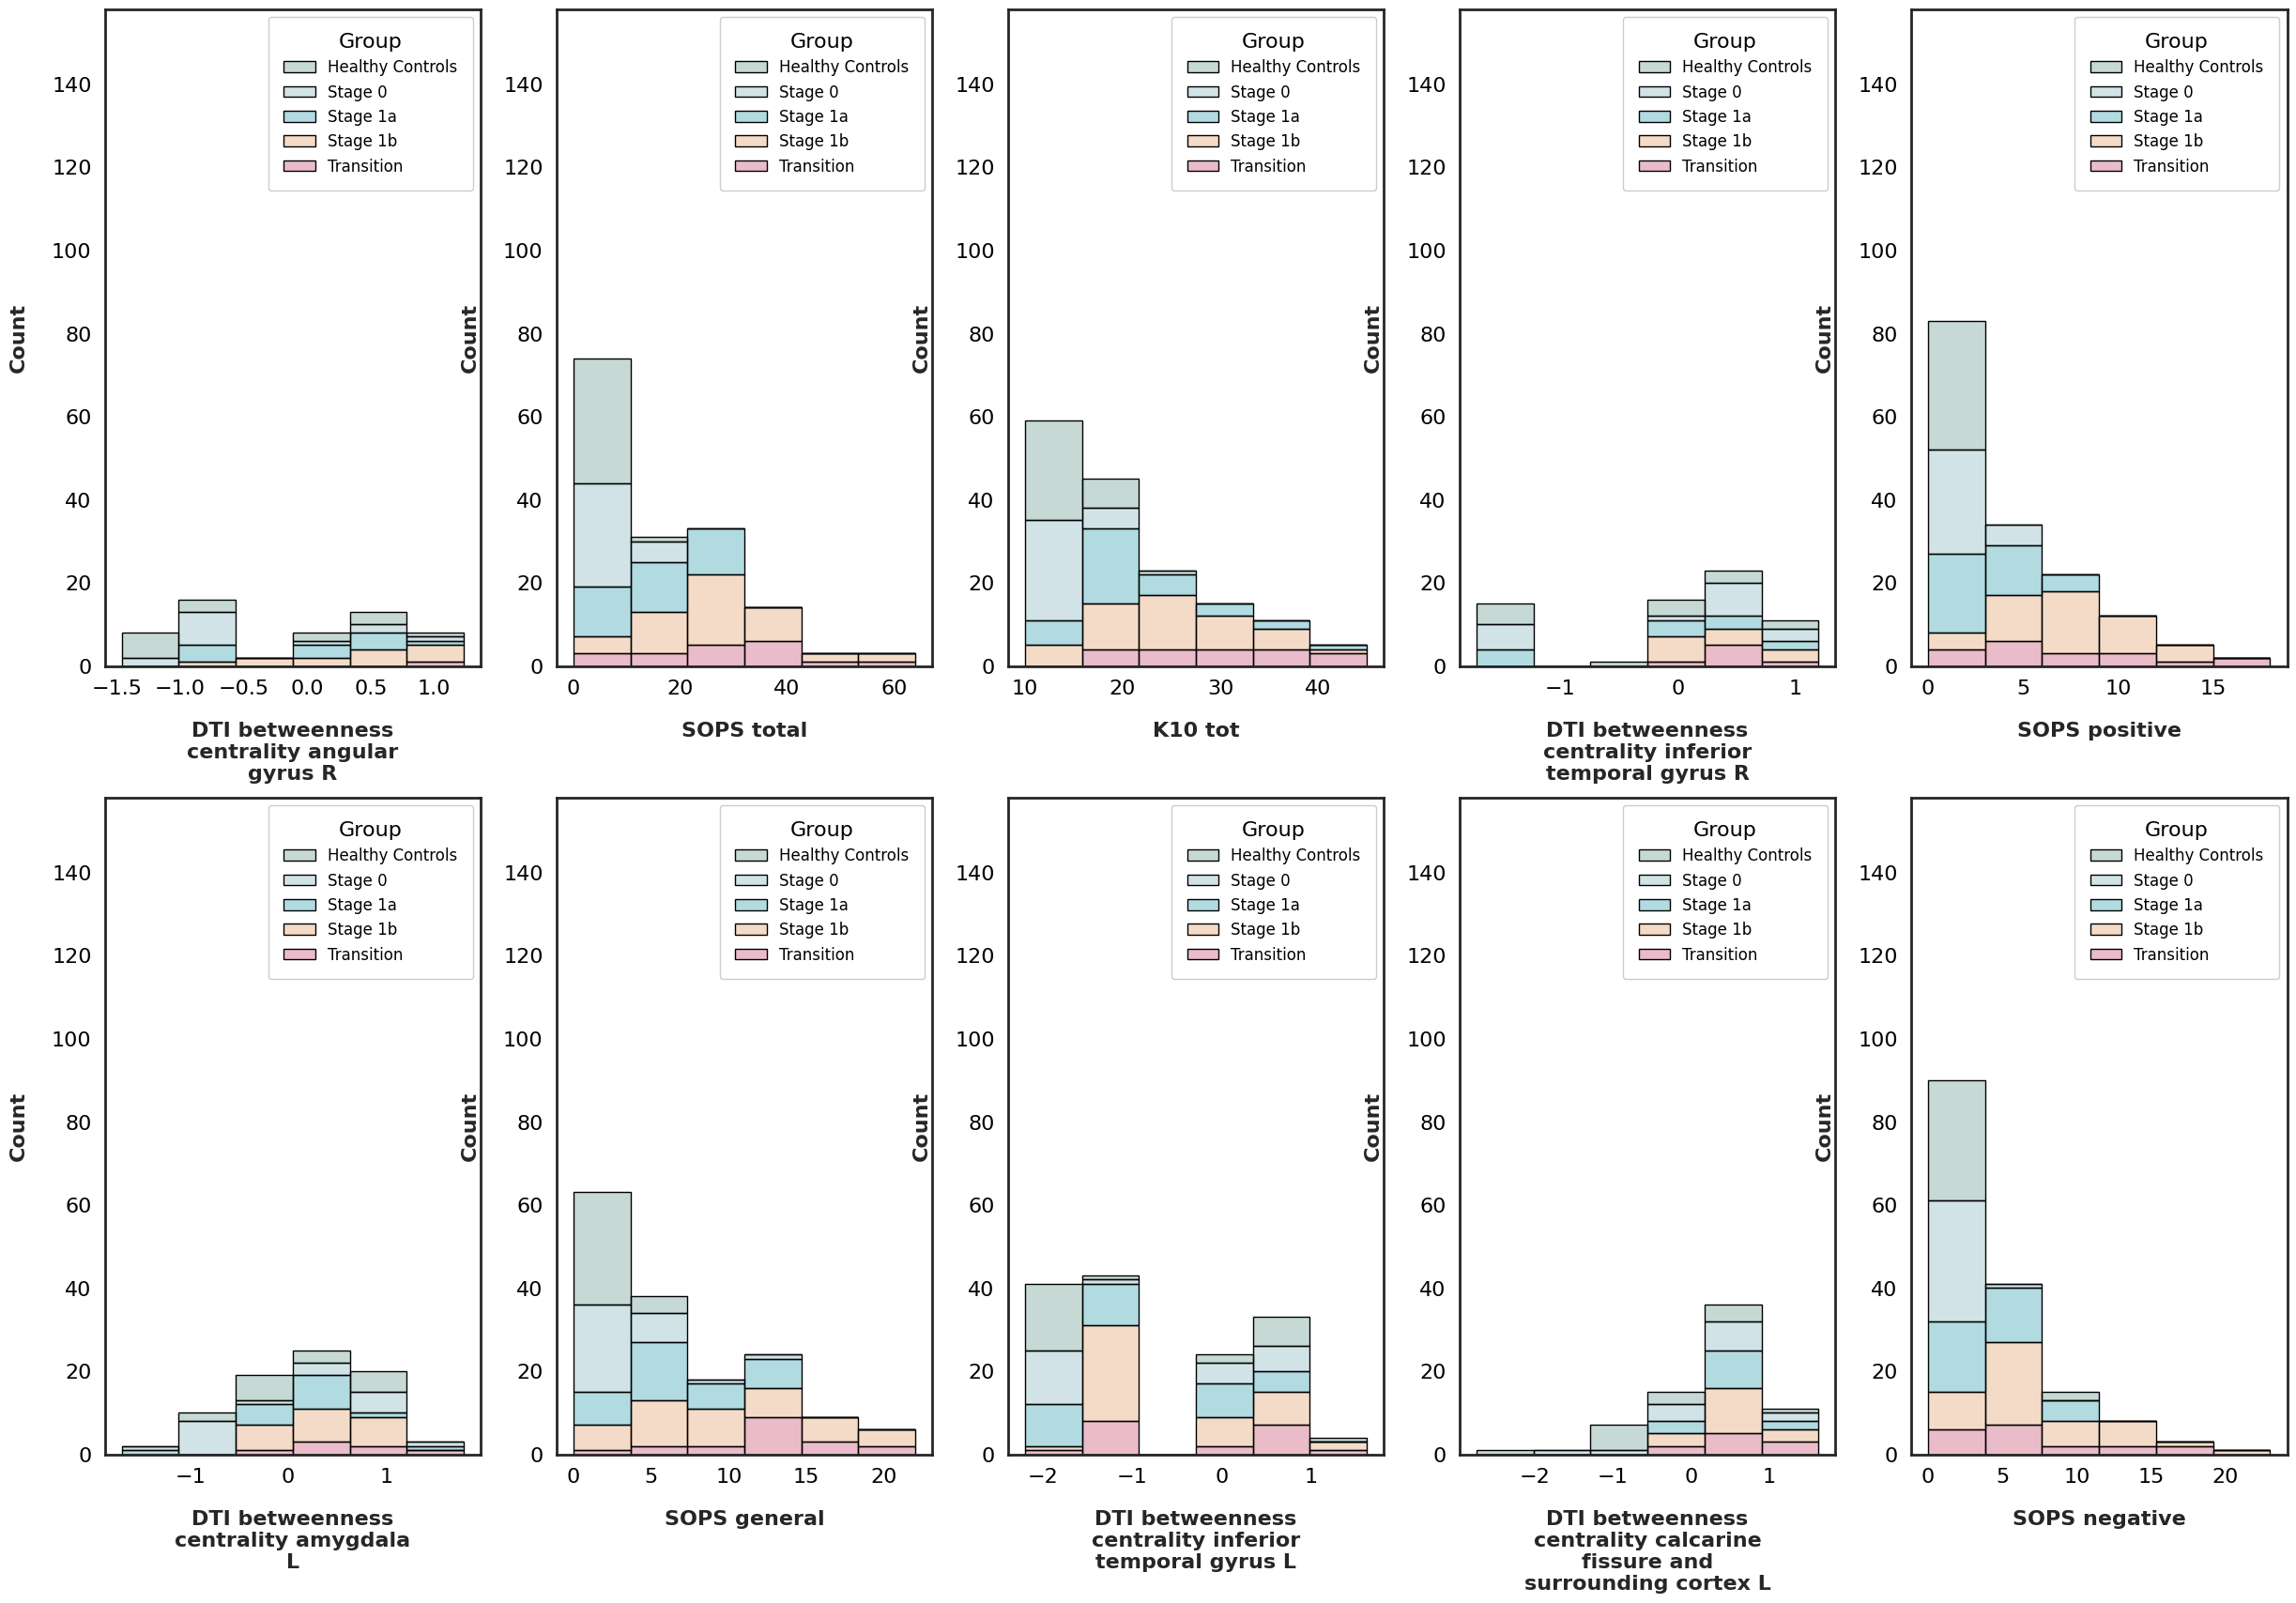

In [ ]:
def plot_feature_hist(data, features, style_sheet="../plots/plt_plot_style.mplstyle", fig_name="transformed-feature-histograms"):
    plt.style.use(style_sheet)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,20))
    flat_axes = []

    for ax in axes:
        for a in ax:
            flat_axes.append(a)
    for f,ax  in list(zip(features, flat_axes)):
        if f[:3] == "DTI":
            data[f] = np.log10(data[f])
        sns.histplot(
            data=data,
            x=f,
            hue="Group",
            hue_order=["Healthy Controls","Stage 0","Stage 1a","Stage 1b","Transition"],
            palette=["#528C80", "#77ACBA", "#1793A4" , "#E09458" ,"#C1355C"],
            kde=False,
            stat="count",
            ax=ax,
            multiple="stack",
            bins=6,
            common_norm=True,
            common_bins=True,
            element="bars",
            alpha=0.33,
            line_kws={'linewidth': 2},
            kde_kws={"cut":0, "cumulative": True})
        ax.set_ylim(0,data.shape[0])

    # plt.ylim(0, 100)
    fig.show()


    # fig.savefig(_PLOT_PATH / f"{fig_name}.svg", bbox_inches="tight")
    # fig.savefig(_PLOT_PATH / f"{fig_name}.pdf", bbox_inches="tight")
    return fig

plot_df = df.copy(deep=True)
plot_df["Group_idx"] = plot_df["Group"]
plot_df["Group"] = plot_df["Group_idx"].map(cfg.labels_dict)
n_m = {c: feature_name_map(c) for c in plot_df.columns}

hist_feature_mapper = lambda x: feature_name_map(x, wrap_len=20)

feature_importances_df = (
                best_model.importances_.fillna(0).mean(axis=1).rename("Importance")
            )
feature_importances_df = feature_importances_df.rename(hist_feature_mapper)
top_10_features=feature_importances_df.sort_values(ascending=False)[:10].index
plot_df= plot_df.rename(columns=hist_feature_mapper)
df_T = df_T.rename(columns=hist_feature_mapper)


# plot_feature_hist(df_T, top_10_features)
_=plot_feature_hist(plot_df, top_10_features, fig_name="raw-feature-histograms")
# plot_feature_hist(df_T, top_10_features, fig_name="transformed-feature-histograms-apa", style_sheet="../plots/apa_plot_style.mplstyle")
# plot_feature_hist(plot_df, top_10_features, fig_name="raw-feature-histograms-apa", style_sheet="../plots/apa_plot_style.mplstyle")


C:\Users\zeyad\AppData\Local\Temp\ipykernel_39404\3869991460.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


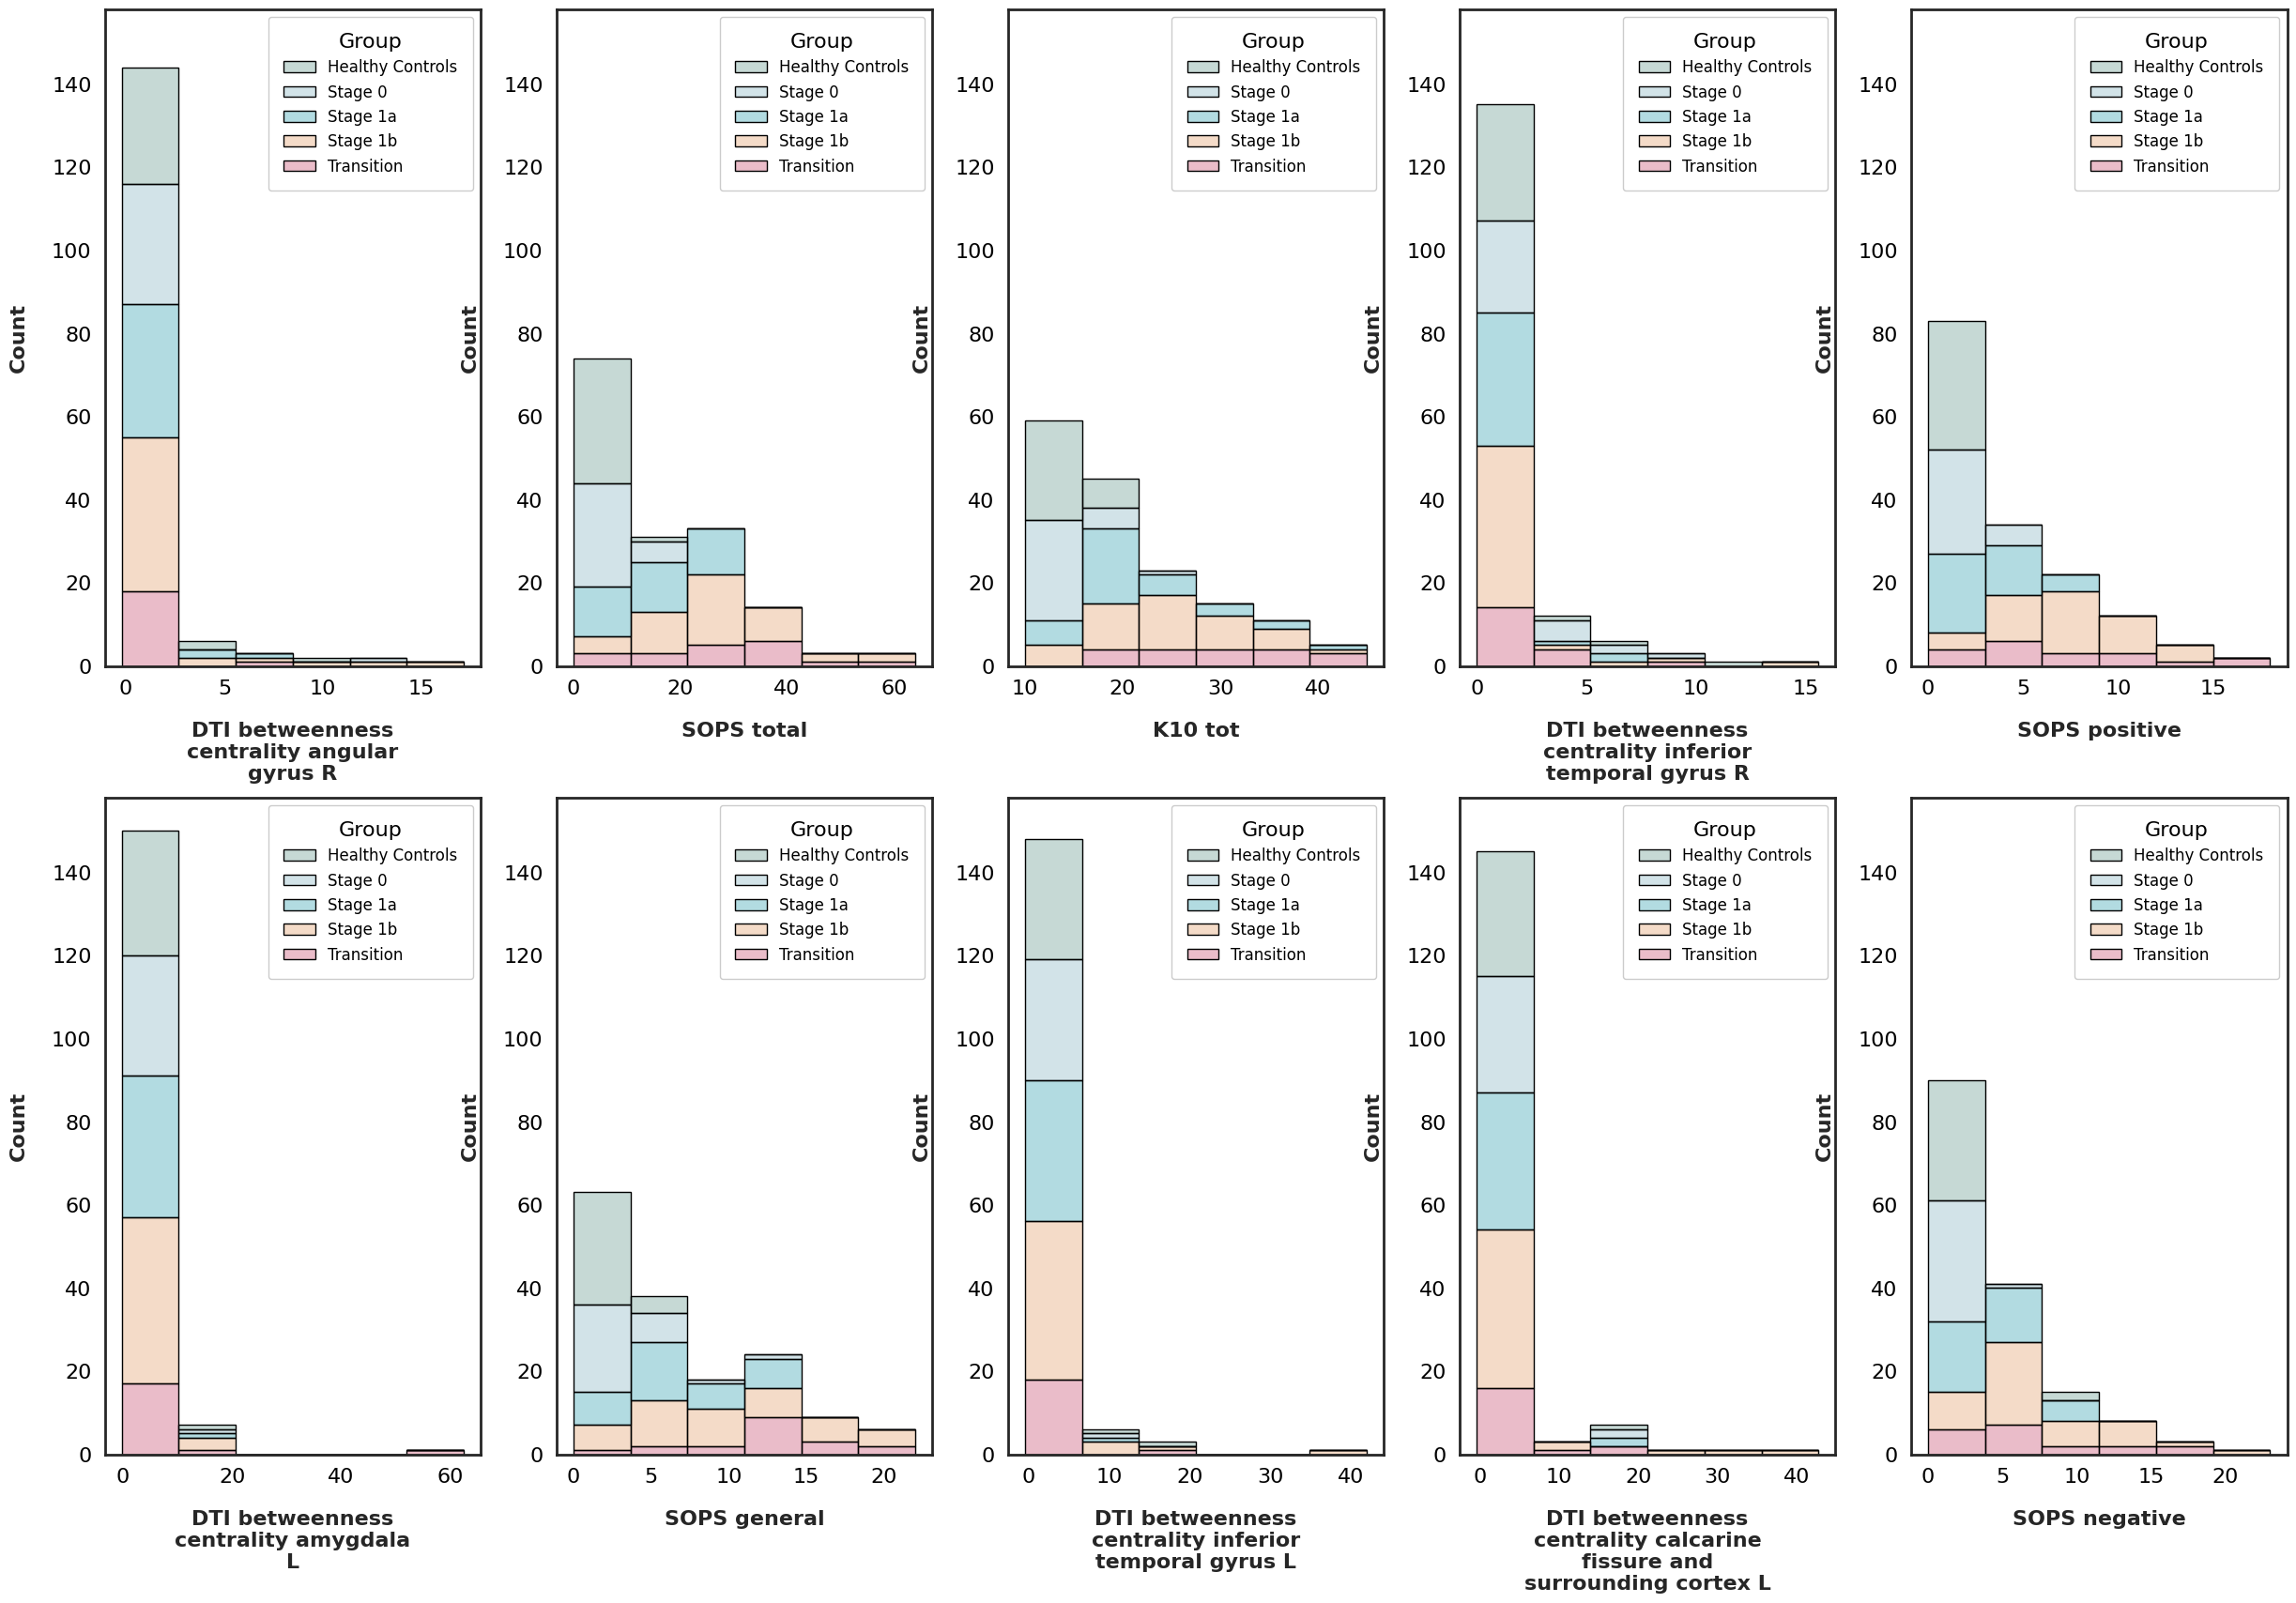

In [ ]:
def plot_feature_hist(data, features, style_sheet="../plots/plt_plot_style.mplstyle", fig_name="transformed-feature-histograms"):
    plt.style.use(style_sheet)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,20))
    flat_axes = []

    for ax in axes:
        for a in ax:
            flat_axes.append(a)
    for f,ax  in list(zip(features, flat_axes)):
        sns.histplot(
            data=data,
            x=f,
            hue="Group",
            hue_order=["Healthy Controls","Stage 0","Stage 1a","Stage 1b","Transition"],
            palette=["#528C80", "#77ACBA", "#1793A4" , "#E09458" ,"#C1355C"],
            kde=False,
            stat="count",
            ax=ax,
            multiple="stack",
            bins=6,
            common_norm=True,
            common_bins=True,
            element="bars",
            alpha=0.33,
            line_kws={'linewidth': 2},
            kde_kws={"cut":0, "cumulative": True})
        ax.set_ylim(0,data.shape[0])

    # plt.ylim(0, 100)
    fig.show()


    fig.savefig(_PLOT_PATH / f"{fig_name}.svg", bbox_inches="tight")
    fig.savefig(_PLOT_PATH / f"{fig_name}.pdf", bbox_inches="tight")
    return fig

plot_df = df.copy(deep=True)
plot_df["Group_idx"] = plot_df["Group"]
plot_df["Group"] = plot_df["Group_idx"].map(cfg.labels_dict)
n_m = {c: feature_name_map(c) for c in plot_df.columns}

hist_feature_mapper = lambda x: feature_name_map(x, wrap_len=20)

feature_importances_df = (
                best_model.importances_.fillna(0).mean(axis=1).rename("Importance")
            )
feature_importances_df = feature_importances_df.rename(hist_feature_mapper)
top_10_features=feature_importances_df.sort_values(ascending=False)[:10].index
plot_df= plot_df.rename(columns=hist_feature_mapper)
df_T = df_T.rename(columns=hist_feature_mapper)


# plot_feature_hist(df_T, top_10_features)
_=plot_feature_hist(plot_df, top_10_features, fig_name="raw-feature-histograms")
# plot_feature_hist(df_T, top_10_features, fig_name="transformed-feature-histograms-apa", style_sheet="../plots/apa_plot_style.mplstyle")
# plot_feature_hist(plot_df, top_10_features, fig_name="raw-feature-histograms-apa", style_sheet="../plots/apa_plot_style.mplstyle")


C:\Users\zeyad\AppData\Local\Temp\ipykernel_39404\2283639950.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


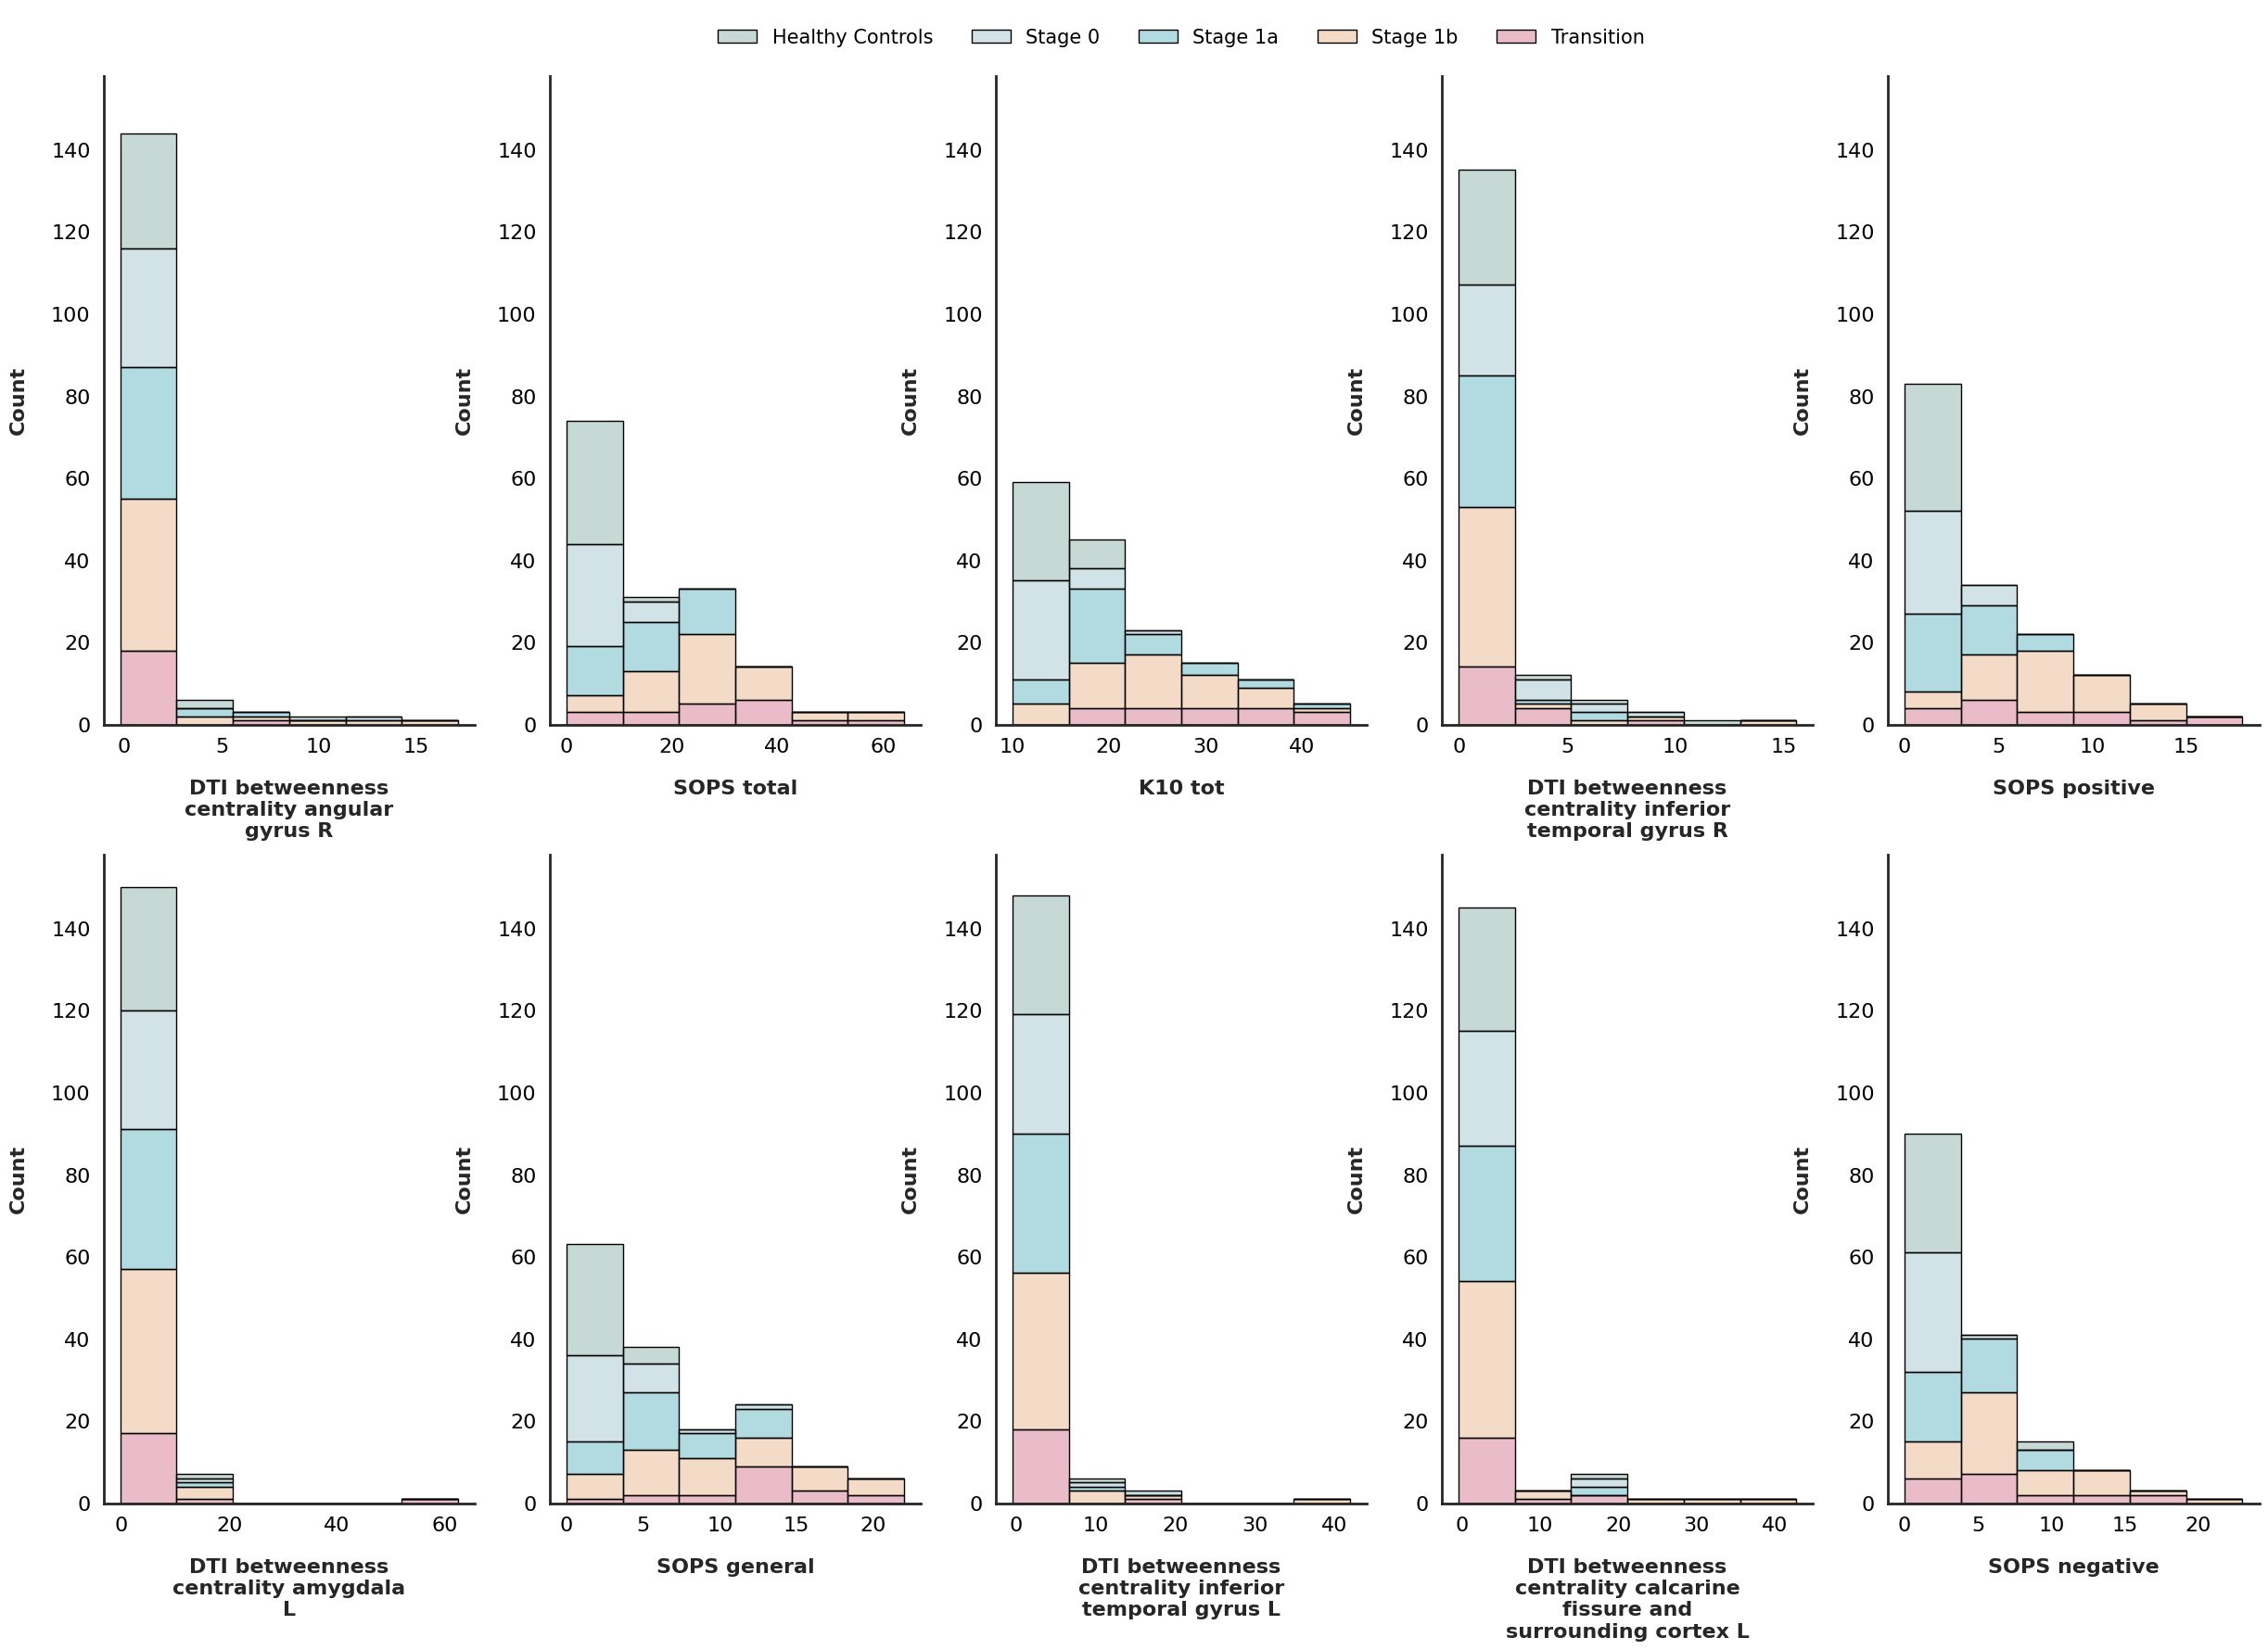

In [ ]:
def plot_feature_hist(data, features, style_sheet="../plots/plt_plot_style.mplstyle", fig_name="transformed-feature-histograms"):
    plt.style.use(style_sheet)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,20))
    flat_axes = []

    for ax in axes:
        for a in ax:
            flat_axes.append(a)
    for f,ax  in list(zip(features, flat_axes)):
        p = sns.histplot(
            data=data,
            x=f,
            hue="Group",
            hue_order=["Healthy Controls","Stage 0","Stage 1a","Stage 1b","Transition"],
            palette=["#528C80", "#77ACBA", "#1793A4" , "#E09458" ,"#C1355C"],
            kde=False,
            stat="count",
            ax=ax,
            multiple="stack",
            bins=6,
            common_norm=True,
            common_bins=True,
            element="bars",
            alpha=0.33,
            line_kws={'linewidth': 2},
            kde_kws={"cut":0, "cumulative": True})
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_ylim(0,data.shape[0])
        ax.get_legend().set_visible(False)
    
    flat_axes[2].get_legend().set_visible(True)
    sns.move_legend(
        flat_axes[2], "lower center",
        bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False, prop={'size': 15}
    )

    # plt.ylim(0, 100)
    fig.show()


    fig.savefig(_PLOT_PATH / f"{fig_name}.svg", bbox_inches="tight")
    fig.savefig(_PLOT_PATH / f"{fig_name}.pdf", bbox_inches="tight")
    return fig

plot_df = df.copy(deep=True)
plot_df["Group_idx"] = plot_df["Group"]
plot_df["Group"] = plot_df["Group_idx"].map(cfg.labels_dict)
n_m = {c: feature_name_map(c) for c in plot_df.columns}

hist_feature_mapper = lambda x: feature_name_map(x, wrap_len=20)

feature_importances_df = (
                best_model.importances_.fillna(0).mean(axis=1).rename("Importance")
            )
feature_importances_df = feature_importances_df.rename(hist_feature_mapper)
top_10_features=feature_importances_df.sort_values(ascending=False)[:10].index
plot_df= plot_df.rename(columns=hist_feature_mapper)
df_T = df_T.rename(columns=hist_feature_mapper)


# plot_feature_hist(df_T, top_10_features)
_=plot_feature_hist(plot_df, top_10_features, fig_name="raw-feature-histograms")
# plot_feature_hist(df_T, top_10_features, fig_name="transformed-feature-histograms-apa", style_sheet="../plots/apa_plot_style.mplstyle")
# plot_feature_hist(plot_df, top_10_features, fig_name="raw-feature-histograms-apa", style_sheet="../plots/apa_plot_style.mplstyle")


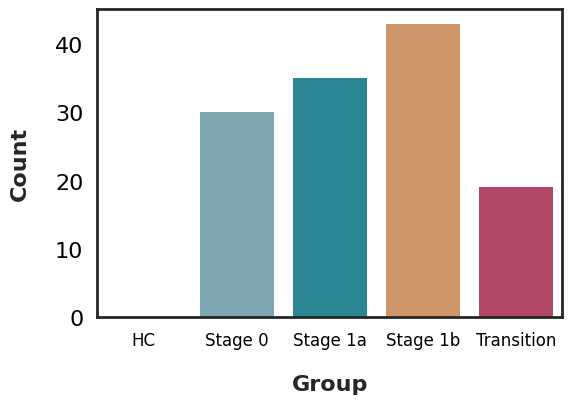

In [ ]:
plt.style.use("../plots/plt_plot_style.mplstyle")
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x=plot_df["Group"].str.replace("_"," "), order=["Healthy Controls","Stage 0", "Stage 1a", "Stage 1b", "Transition"], palette=["#528C80", "#77ACBA", "#1793A4" , "#E09458" ,"#C1355C"], ax=ax) #, color=sns.color_palette()[0], ax=ax)
ax.set_ylabel("Count")
plt.xticks(fontsize=12)
fig.savefig(_PLOT_PATH / "label-counts.pdf", bbox_inches="tight")
fig.savefig(_PLOT_PATH / "label-counts.svg", bbox_inches="tight")